# Face Recognition

Lets get a overview of steps in performing face recognition.
- Data preprocessing using `opencv` on raw images data to get feature vectors.
- Dimensionality reduction using `PCA` of image feature vectors.
- Modeling using `1-NN`.
  
------

Lets import all the required modules,
- In the below cell, to choose top `x` eigen values change the n_components variable
- Choose `image_vector_size` as you needed which indicates the resize pixels of image.
- `n_training_folders` indicates number of folders in training face_data.
- `m_training_images` indicates images in each `n_training_folders`.
- `n_testing_folders` indicates number of folders in testing face_data.
- `m_testing_images` indicates images in each `n_testing_folders`.

In [103]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n_components = 5
image_vector_size = 100

n_training_folders = 10
m_training_images = 10

n_testing_folders = 10
m_testing_images = 3

## Data preprocessing

Now lets create our own data `Preprocessor` class which takes training, testing and cascade paths as input and returns us the image vectors of rect (here face) with labels according to the given haarcascade. It contains two functions:
- `get_training_data`: which returns face vectors matrix and its labels where both are np.arrays. With in the function:
  - Calls private function __prepare_data__ based on training or testing and reads all the images using opencv tool by looping according to the folder structure given at the start of class creation.
  - Above function calls another helper function which is __detect_face__ which uses haarcascade tool provided by opencv to detect the facial part of the given image. And return its vector.
  - With the returned face vector of each image forms an array of detected faces, and array of labels according to their folder name and returns both.
- `get_testing_data`: this performs similar task but with testing data.

In [104]:
class Preprocess():
	def __init__(self, training_path, testing_path, cascade_path):
		"""
		Called when class is created with the variables of data
		"""
		self.training_path = training_path
		self.testing_path = testing_path
		self.cascade_path = cascade_path
	
	def __detect_face__(self, img):
		"""
		Method which perform face detection using haarcascade tool.
		img: cv2 BGR plane image
		returns: coordinated face of the given image, coordinates
		"""
		detector = cv2.CascadeClassifier(self.cascade_path)
		face = detector.detectMultiScale(img, minNeighbors=3)
		img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
		if len(face) == 0:
				return (-1, -1)
		(x, y, w, h) = face[0]
		return (img[y:y+w, x:x+h], face[0])

	def __prepare_data__(self, path, type = "Training"):
			"""
			path: string where training image folders are present
			returns: detected faces and their labels(names of folders where group of images are present)
			"""
			detected_faces = []
			face_labels = []
			img_dir = os.listdir(path)
			for dir_name in img_dir:
					label = str(dir_name)
					if not label.startswith("."):
							img_names = os.listdir(path + '/' + dir_name)
							for img_name in img_names:
									if not img_name.startswith("."):
											img_path = path + '/' + dir_name + '/' + img_name
											img = cv2.imread(img_path)
											face, _ = self.__detect_face__(img)
											resized_face = cv2.resize(face, (image_vector_size, image_vector_size), interpolation = cv2.INTER_AREA)
											p = "Build/Face_data" + '/' + type + '/' + label
											if not os.path.exists(p):
													os.makedirs(p)
											cv2.imwrite(p + '/' + img_name, face)
											detected_faces.append(resized_face)
											face_labels.append(label)
			return (np.array(detected_faces), np.array(face_labels))
	
	def get_train_data(self):
		"""
		Method which performs face detection task using detect face function for every image in the training set
		returns: detected faces and their labels(names of folders where group of images are present)
		"""
		return self.__prepare_data__(self.training_path, type="Training")
	
	def get_test_data(self):
		"""
		Method which performs face detection task using detect face function for every image in the testing set
		returns: detected faces and their labels(names of folders where group of images are present)
		"""
		return self.__prepare_data__(self.testing_path, type="Testing")

To visualize the face vectors in a image format lets write a small plot portraits function which prints all the faces with provided labels in a subplot manner using provided number of columns and number of rows.

In [105]:
def plot_portraits(images, titles, h, w, n_row, n_col):
    """
    Method which plots the array of images in a subplot manner
    images: array of image vectors
    title: image labels
    h: rows of image vector
    w: columns of image vector
    n_row: number of rows in subplot
    n_col: number of columns in subplot
    """
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap="gray")
        plt.title(titles[i], color="white")
        plt.xticks(())
        plt.yticks(())

Since we got our required preprocessing data preprocessing function and a portrait visualizer lets get our training and testing data and visualize those gray scaled images to proceed further.

In [106]:
training_path = "Data/Face_data/Train"
testing_path = "Data/Face_data/Test"
harcascade_frontal_face_path = "Cascades/haarcascade_frontalface_alt.xml"

preprocess = Preprocess(training_path, testing_path, cascade_path = harcascade_frontal_face_path)

faces_train, labels_train = preprocess.get_train_data()
faces_test, labels_test = preprocess.get_test_data()
n_samples_train, h, w = faces_train.shape
n_samples_test, h, w = faces_test.shape

Now lets visualize our training dataset images which are preprocessed with opencv to gray scale images using `plot_portraits` function.

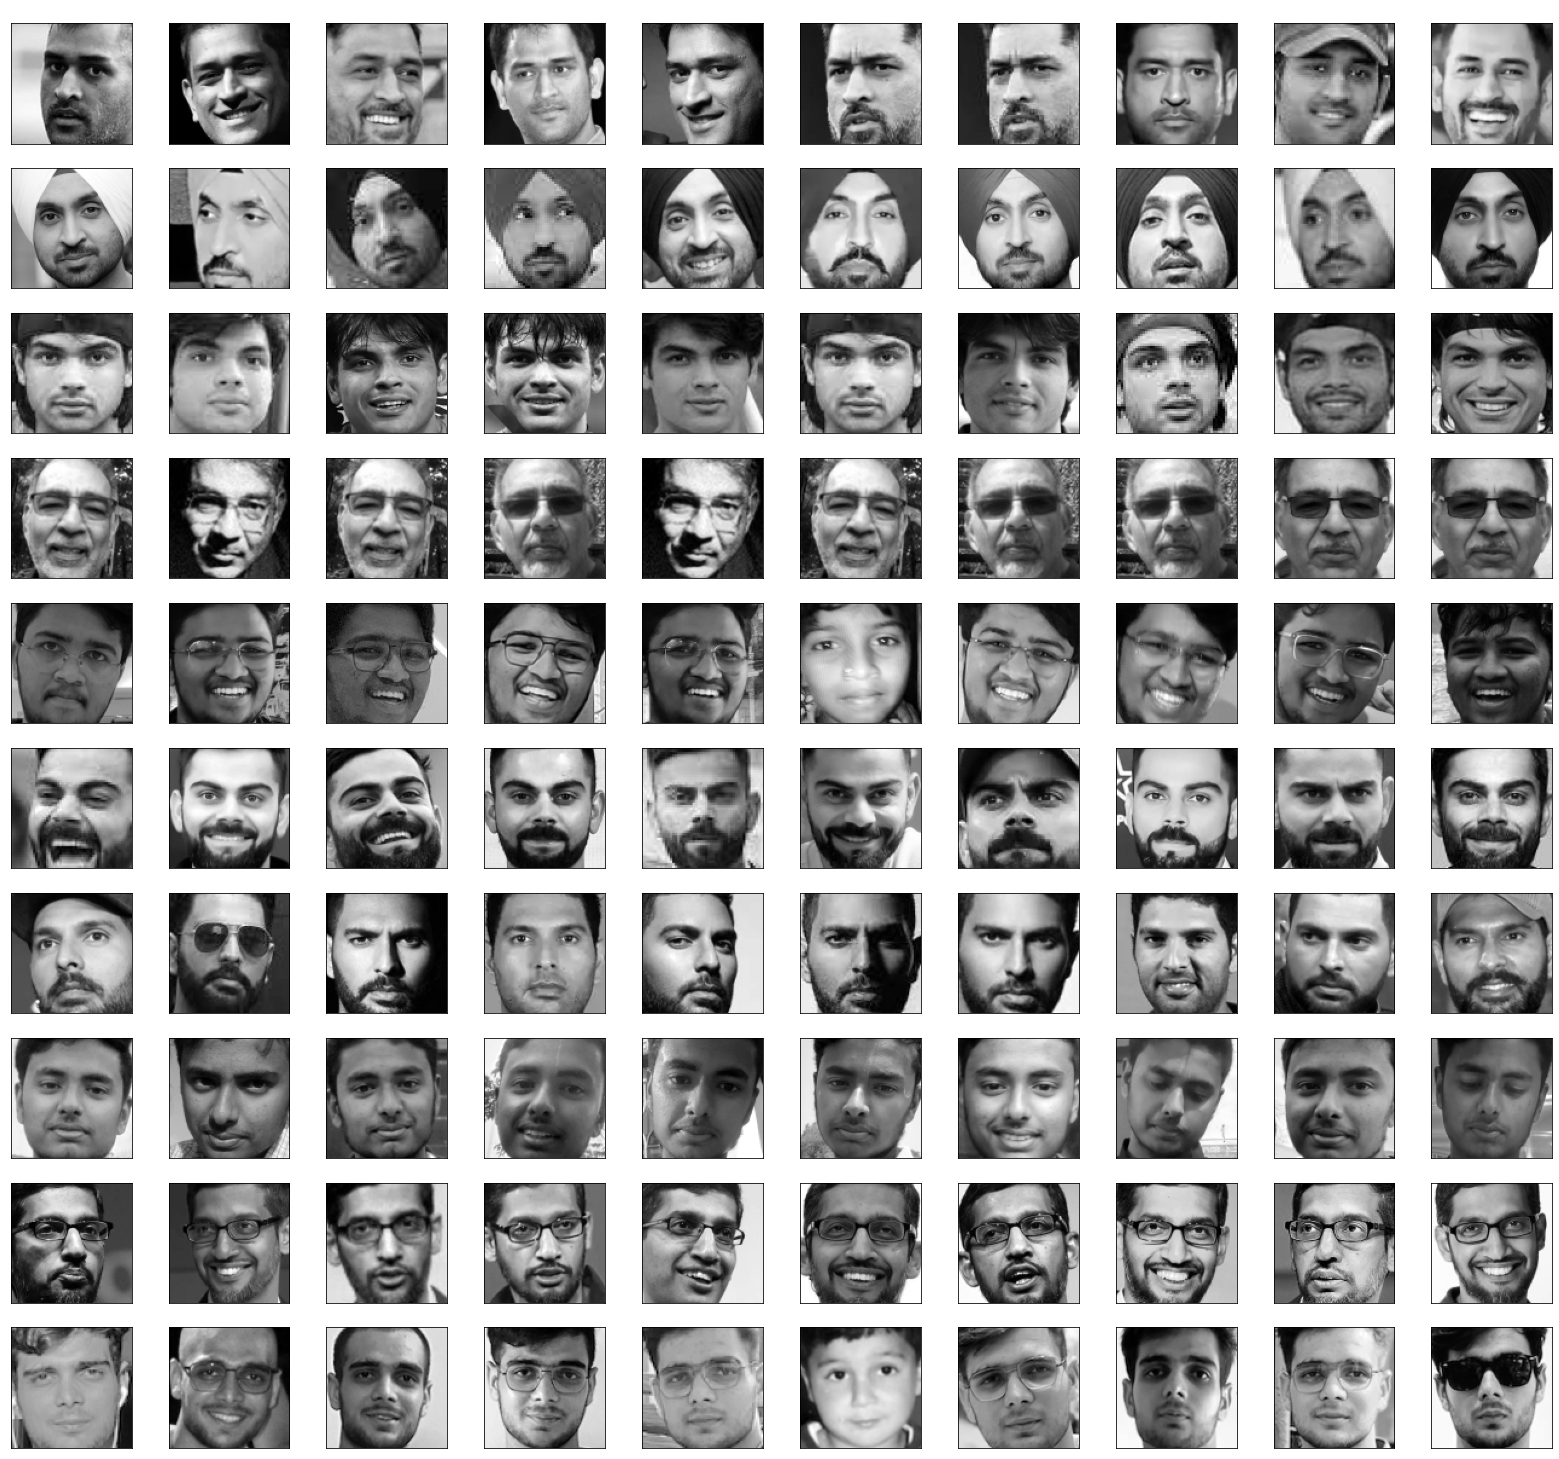

In [107]:
plot_portraits(faces_train, labels_train, h, w, n_row = 10, n_col = 10)

## Dimensionality reduction

Lets perform dimensionality reduction using PCA
1. Make the same image $N \times N$ on face image $I$.
2. Read each training face image, $I = (I_1, I_2, I_3,... I_i )$.
3. Change the dimensions of face image to vector size $1 \times N^2$ and symbolize each image $I_i$ as vector $\Gamma_i$.
4. Calculate the average matrix
$$\psi = \frac{1}{M}\sum_{i=1}^M\Gamma_i$$
5. Substract each face image matrix by its average
$$\phi = \Gamma_i - \psi$$
6. Calculating covariance matrix
$$C = \phi\phi^T$$
where
$$\phi = \begin{bmatrix}\phi_1\\ \phi_2\\ ..\\ \phi_M\end{bmatrix}$$
Because the size of the matris is too large, look for the covariance matrix be:
$$C = \phi^T\phi$$
7. Calculating eigenvalue and eigenvector
$$Cu_i = \lambda u_i$$
$$\text{Eigenvalue}(\lambda) = \text{Det}(C-\lambda I)$$
$$\text{Eigenvector}(u_i) = (C - \lambda I)u_i$$
8. Calculating eigenface ($\mu$)
$$\mu = \sum_{i=1}^Mv_iQ_i$$

Lets define our own PCA function which fits the data and transforms it into lower dimensional space according to above formulas.

In [108]:
class PrincipalComponentAnalysis():
    def __init__(self, n_components):
        self.n_components = n_components
    
    def fit(self, X):
        """
        Method which calculates eigen vectors and their projections in the eigen space of given data covariance matrix
        X: input data of faces
        returns:
        - C: principal components which are top n eigen vectors
        - P: projection of these eigenvectors into eigen space
        - M: mean vector of input data
        - N: normalized input data
        """
        self.mean_vector = X.mean(axis=1)
        self.mean_vector = self.mean_vector.reshape(X.shape[0], 1)
        normalized_data = X - self.mean_vector
        cov = np.cov(normalized_data.T)
        eig_val, eig_vec = np.linalg.eig(cov)
        idx = eig_val.argsort()[::-1]   
        eig_val = eig_val[idx]
        eig_vec = eig_vec[:,idx]
        print(eig_val[:self.n_components])
        print(eig_val[-self.n_components:-1])
        self.eig_vectors = (eig_vec[:self.n_components]).real
        self.eig_faces = self.eig_vectors.dot(normalized_data.T).real
        print(self.eig_vectors.shape, self.eig_faces.shape)
        return (self.eig_vectors, self.eig_faces)

    def transform(self, X):
        """
        Method which reduces the given data to k dimensional format
        X: input data of faces
        returns:
        - reduces_data: which is lower dimensional representation of given data in higher dimension
        """
        normalized_data = X - self.mean_vector
        reduced_data = normalized_data.T.dot(self.eig_faces.T)
        return reduced_data

    def inverse_transform(self, X):
        """
        Method which inverse transforms lower dimensional data to higher dimensional data
        X: input data of faces
        returns:
        - original_data: which is higher dimensional representation of given data (original of reduced)
        """
        print(X.shape, self.eig_faces.shape, self.mean_vector.shape)
        return X.dot(self.eig_faces) + self.mean_vector.T

As we got our own PCA, lets fit the data and get eigen faces

In [109]:
data_train = faces_train.reshape(n_samples_train, h*w)
pca = PrincipalComponentAnalysis(n_components=n_components)
eig_vec_train, eig_faces_train = pca.fit(data_train.T) 

[49909.67474615+0.j 29873.04566975+0.j 23082.30390786+0.j
 15068.38594375+0.j 13002.68527594+0.j]
[ 6.18446661e-14-9.95168415e-15j -8.36916604e-14+1.40650788e-13j
 -8.36916604e-14-1.40650788e-13j -2.28780128e-13+0.00000000e+00j]
(5, 100) (5, 10000)


In the above cell, 
- `C` represents top `n_components` of eigen vectors.
- `P` represent the projection of those `C` eigen vectors into eigen space which are nothing but top `n_components` facial representation of given face data.
- `M` represents mean vector of the given data.
- `N` represent the normalized representation of data that is unique representation of each face excluding common among all faces.

Now lets visualize these eigen faces using `plot_portrait` function

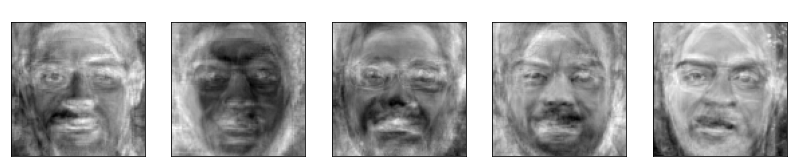

In [110]:
eig_titles_train = [f"Eigenface {i+1}" for i in range(eig_faces_train.shape[0])]
plot_portraits(eig_faces_train, eig_titles_train, h, w, 1, 5)

For the lower dimensional representation of our data lets transform using the pca and store it with their corresponding labels for modeling.

In [111]:
reduced_train_data = pca.transform(data_train.T)
training_data = pd.DataFrame(reduced_train_data) 
training_data["labels"] = labels_train
X_train = training_data[[column for column in training_data.columns if column != "labels"]]
y_train = training_data["labels"]
training_data.head()

0             1             2             3             4  \
0 -3.888622e+06  3.771315e+07  9.868238e+06 -8.059041e+05  2.500841e+06   
1 -6.895879e+06 -2.193051e+07 -1.102425e+07  5.773982e+06  1.191577e+07   
2  4.063457e+06  1.294532e+07  6.934792e+06 -5.694076e+06  5.416815e+05   
3  1.275410e+07 -1.965523e+07  1.203562e+06 -7.361836e+06  1.010924e+07   
4 -1.686410e+06 -1.575150e+07 -6.425712e+06  2.815907e+05  8.768949e+06   

      labels  
0  M.S Dhoni  
1  M.S Dhoni  
2  M.S Dhoni  
3  M.S Dhoni  
4  M.S Dhoni

## Inverse transformation of faces

To get the whole data use these `n_components` eigen faces and generate whole data using the mean vector by multiplying projections of top `n_components` principal components. And also lets visualize the inverse transformed images.

(100, 5) (5, 10000) (10000, 1)


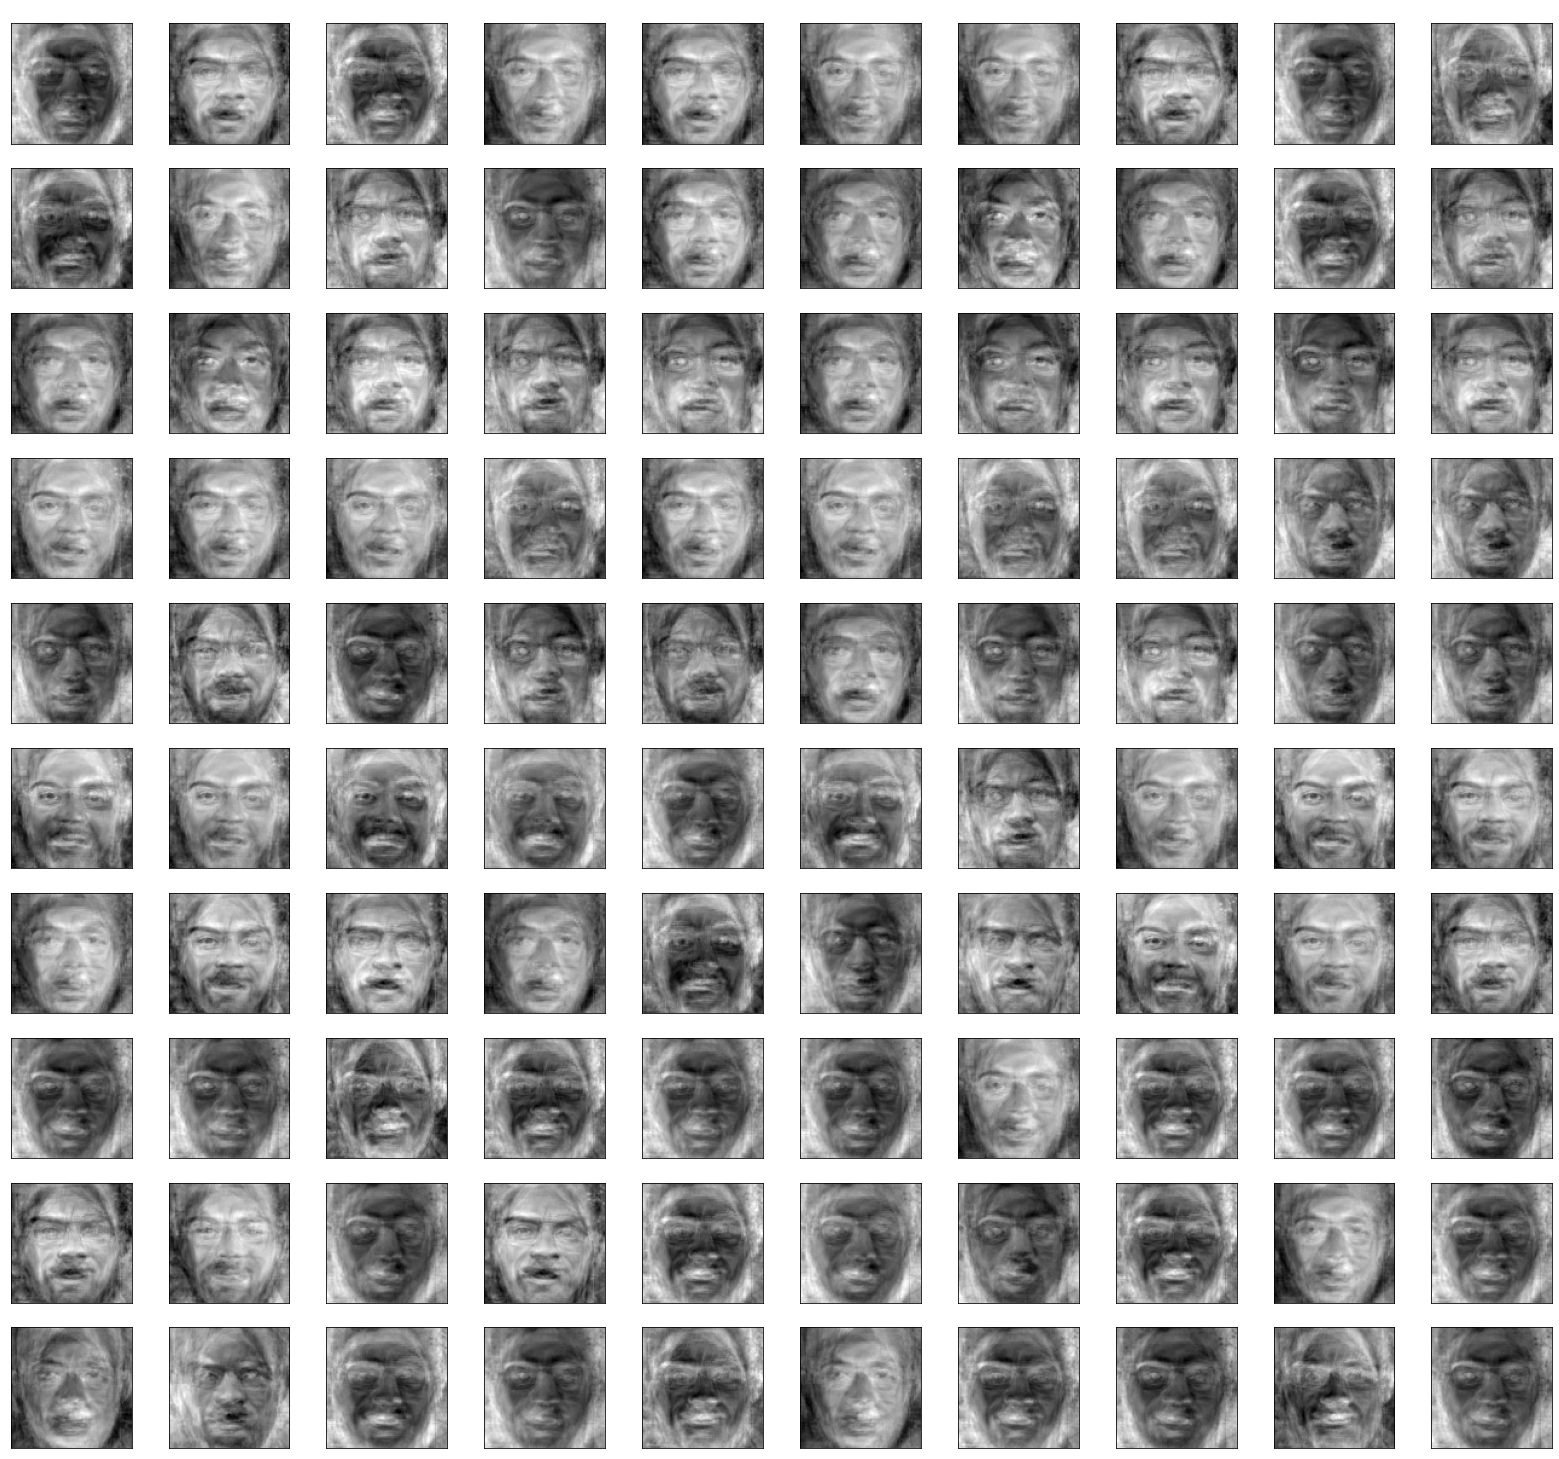

In [112]:
eig_faces_inverse_train = pca.inverse_transform(reduced_train_data)
plot_portraits(eig_faces_inverse_train, labels_train, h, w, 10, 10)

(30, 5) (5, 10000) (10000, 1)


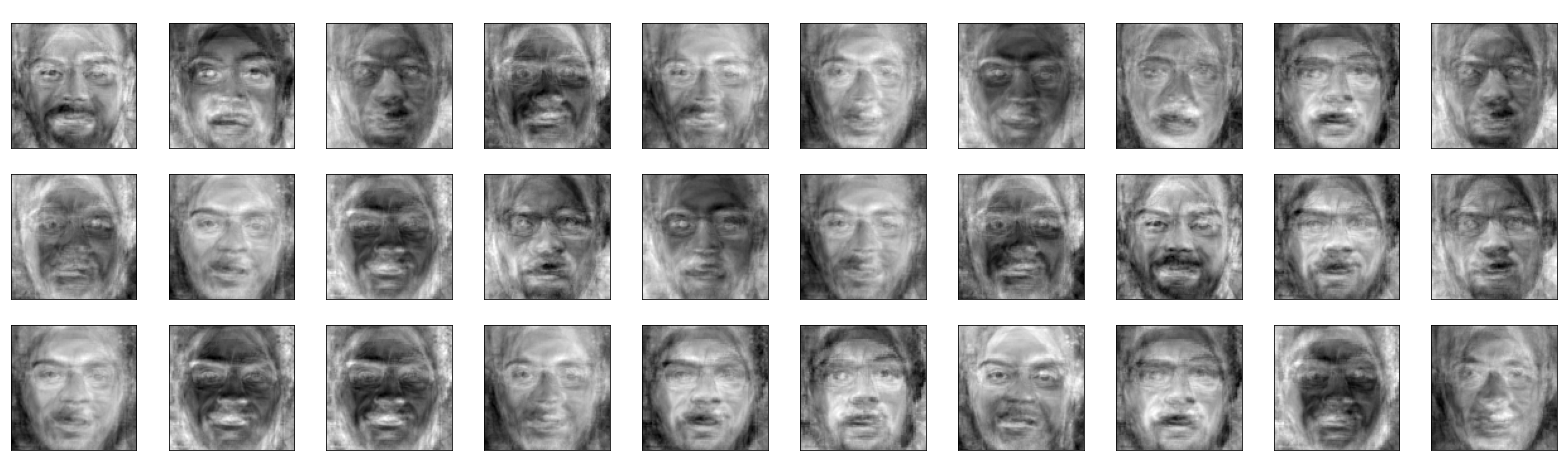

In [113]:
data_test = faces_test.reshape(n_samples_test, h*w)
reduced_test_data = pca.transform(data_test.T)
test_data = pd.DataFrame(reduced_test_data)
test_data["labels"] = labels_test
X_test = test_data[[column for column in test_data.columns if column != "labels"]]
y_test = test_data["labels"]

## ----- Inverse transformation of test data -----
eig_faces_inverse_test = pca.inverse_transform(reduced_test_data)
plot_portraits(eig_faces_inverse_test, labels_test, h, w, 3, 10)

Since we got both training and test data in required dimension format lets build a model to classify these.

## Modeling with 1-NN

Let us define our own KNN classifier which detects based on the euclidean distance metric.

In [114]:
import scipy.spatial

class KNN:
		def __init__(self, k):
				self.k = k
				
		def fit(self, X, y):
				self.X_train = X
				self.y_train = y
				
		def distance(self, X1, X2):
				distance = scipy.spatial.distance.euclidean(X1, X2)
				return distance
		
		def predict(self, X_test):
				final_output = []
				for i in range(len(X_test)):
						d = []
						outputs = []
						for j in range(len(X_train)):
								dist = self.distance(X_train.iloc[j] , X_test.iloc[i])
								d.append([dist, j])
						d.sort()
						d = d[0:self.k]
						for d, j in d:
								outputs.append(y_train.iloc[j])
						results = []
						ans = max(set(outputs), key = outputs.count)
						final_output.append(ans)
						
				return final_output
		
		def score(self, X_test, y_test):
				predictions = self.predict(X_test)
				return (predictions == y_test).sum() / len(y_test)



In [115]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNN(k=1)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(f"Accuracy score using user defined 1-NN: {score}")

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(f"Accuracy score using inbuilt 1-NN: {score}")

y_pred = clf.predict(X_test)

X_test.shape

Accuracy score using user defined 1-NN: 0.23333333333333334
Accuracy score using inbuilt 1-NN: 0.23333333333333334


(30, 5)

## Using builtin

Accuracy score using inbuilt 1-NN: 0.2


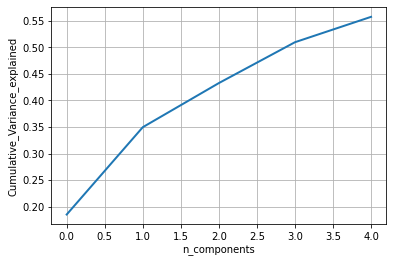

In [116]:
from sklearn.decomposition import PCA

# Dimensionality reduction
pca = PCA(n_components = n_components)
X_train_builtin = faces_train.reshape(n_samples_train, h*w)
X_test_builtin = faces_test.reshape(n_samples_test, h*w)
pca.fit(X_train_builtin)
X_train_builtin = pd.DataFrame(pca.transform(X_train_builtin))
X_test_builtin = pd.DataFrame(pca.transform(X_test_builtin))


clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train_builtin, y_train)
score = clf.score(X_test_builtin, y_test)
print(f"Accuracy score using inbuilt 1-NN: {score}")

# PCA principal components variation visualization
percentage_var_explained = pca.explained_variance_ratio_;  
cum_var_explained=np.cumsum(percentage_var_explained)

plt.figure(1,figsize=(6,4))
plt.clf()  
plt.plot(cum_var_explained,linewidth=2)  
plt.axis('tight')  
plt.grid() 
plt.xlabel('n_components') 
plt.ylabel('Cumulative_Variance_explained')  
plt.show()

In [117]:
# from time import time
# from sklearn.decomposition import PCA

# n_components = 100

# X_train_builtin = faces_train.reshape(n_samples_train, h*w)
# X_test_builtin = faces_test.reshape(n_samples_test, h*w)
 
# t0 = time()
# pca = PCA(n_components = n_components, svd_solver ='randomized',
#           whiten = True).fit(X_train_builtin)

# print("done in % 0.3fs" % (time() - t0))
 
# eigenfaces = pca.components_.reshape((n_components, h, w))
 
# print("Projecting the input data on the eigenfaces orthonormal basis")
# t0 = time()
# X_train_pca = pca.transform(X_train_builtin)
# X_test_pca = pca.transform(X_test_builtin)
# print("done in % 0.3fs" % (time() - t0))

# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report
# from sklearn.svm import SVC

# print("Fitting the classifier to the training set")
# t0 = time()
# param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
#               'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
# clf = GridSearchCV(
#     SVC(kernel ='rbf', class_weight ='balanced'), param_grid
# )
# clf = clf.fit(X_train_pca, y_train)
# print("done in % 0.3fs" % (time() - t0))
# print("Best estimator found by grid search:")
# print(clf.best_estimator_)
 
# print("Predicting people's names on the test set")
# t0 = time()
# y_pred = clf.predict(X_test_pca)
# print("done in % 0.3fs" % (time() - t0))
# # print classification results
# y_pred